# King County - XGBoost

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.layers import Normalization
import seaborn as sns
from xgboost import XGBRegressor

## Getting data ready
First We'll have some intuition on the data and set the "id" as index value. Also remove duplicate values.

In [2]:
df = pd.read_csv('./kc_house_data.csv')
df.set_index('id', inplace=True)
df = df[~df.index.duplicated(keep='first')]
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


From date which is an object, "str" in this dataset, we'll have to convert to date and take year and month which is important to our model.

In [3]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df = df.drop('date', axis=1)
prices = df['price']
df = df.drop('price', axis=1)
df['price'] = prices
df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,price
id,,,,,,,,,,,,,,,,,,,,,
7129300520,3,1.00,1180,5650,1.0,0,0,3,7,1180,...,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,221900.0
6414100192,3,2.25,2570,7242,2.0,0,0,3,7,2170,...,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,538000.0
5631500400,2,1.00,770,10000,1.0,0,0,3,6,770,...,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,180000.0
2487200875,4,3.00,1960,5000,1.0,0,0,5,7,1050,...,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,604000.0
1954400510,3,2.00,1680,8080,1.0,0,0,3,8,1680,...,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,510000.0


Have an intuition on what columns contain null values and what their Dtypes are

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21436 entries, 7129300520 to 1523300157
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       21436 non-null  int64  
 1   bathrooms      21436 non-null  float64
 2   sqft_living    21436 non-null  int64  
 3   sqft_lot       21436 non-null  int64  
 4   floors         21436 non-null  float64
 5   waterfront     21436 non-null  int64  
 6   view           21436 non-null  int64  
 7   condition      21436 non-null  int64  
 8   grade          21436 non-null  int64  
 9   sqft_above     21436 non-null  int64  
 10  sqft_basement  21436 non-null  int64  
 11  yr_built       21436 non-null  int64  
 12  yr_renovated   21436 non-null  int64  
 13  zipcode        21436 non-null  int64  
 14  lat            21436 non-null  float64
 15  long           21436 non-null  float64
 16  sqft_living15  21436 non-null  int64  
 17  sqft_lot15     21436 non-null  int64

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,21436.0,3.371571,0.929205,0.0000,3.0000,3.000,4.000,3.300000e+01
bathrooms,21436.0,2.117349,0.769913,0.0000,1.7500,2.250,2.500,8.000000e+00
sqft_living,21436.0,2082.704936,919.146469,290.0000,1430.0000,1920.000,2550.000,1.354000e+04
sqft_lot,21436.0,15135.637852,41538.620606,520.0000,5040.0000,7614.000,10696.250,1.651359e+06
floors,21436.0,1.496198,0.540388,1.0000,1.0000,1.500,2.000,3.500000e+00
waterfront,21436.0,0.007604,0.086871,0.0000,0.0000,0.000,0.000,1.000000e+00
view,21436.0,0.235118,0.767092,0.0000,0.0000,0.000,0.000,4.000000e+00
condition,21436.0,3.410384,0.650235,1.0000,3.0000,3.000,4.000,5.000000e+00
grade,21436.0,7.661737,1.174256,1.0000,7.0000,7.000,8.000,1.300000e+01
sqft_above,21436.0,1790.960440,829.026491,290.0000,1200.0000,1560.000,2220.000,9.410000e+03


In [6]:
(df == 0).sum()

bedrooms            13
bathrooms           10
sqft_living          0
sqft_lot             0
floors               0
waterfront       21273
view             19320
condition            0
grade                0
sqft_above           0
sqft_basement    13015
yr_built             0
yr_renovated     20526
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
year                 0
month                0
price                0
dtype: int64

Correlation of two values gives a great insight on what features impact the values of each other

In [7]:
df.corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,price
bedrooms,1.000000,0.516772,0.577512,0.031719,0.175207,-0.006685,0.079542,0.027896,0.358396,0.478441,...,0.153745,0.018435,-0.153621,-0.010228,0.129836,0.393161,0.029117,-0.010065,-0.000413,0.309007
bathrooms,0.516772,1.000000,0.754422,0.087143,0.499863,0.063734,0.186684,-0.127839,0.664727,0.684994,...,0.505092,0.051101,-0.202958,0.023444,0.221935,0.568194,0.086627,-0.023215,0.005427,0.525453
sqft_living,0.577512,0.754422,1.000000,0.171957,0.352867,0.103902,0.283753,-0.060973,0.762402,0.876683,...,0.316544,0.055084,-0.198621,0.051118,0.239214,0.756205,0.182775,-0.025818,0.010058,0.701993
sqft_lot,0.031719,0.087143,0.171957,1.000000,-0.005950,0.021571,0.075012,-0.009298,0.112541,0.182581,...,0.052447,0.007636,-0.129411,-0.085992,0.229555,0.143650,0.718097,0.005981,-0.002557,0.088895
floors,0.175207,0.499863,0.352867,-0.005950,1.000000,0.023473,0.028211,-0.266543,0.457475,0.522648,...,0.489062,0.005626,-0.058108,0.049279,0.124285,0.278854,-0.011917,-0.018709,0.011864,0.256278
waterfront,-0.006685,0.063734,0.103902,0.021571,0.023473,1.000000,0.403025,0.016607,0.082841,0.072021,...,-0.026537,0.093025,0.030558,-0.014395,-0.042188,0.086558,0.030694,-0.003444,0.007724,0.266961
view,0.079542,0.186684,0.283753,0.075012,0.028211,0.403025,1.000000,0.045051,0.249890,0.166930,...,-0.055153,0.103633,0.087096,0.005671,-0.079720,0.279077,0.072867,0.003066,-0.006918,0.396933
condition,0.027896,-0.127839,-0.060973,-0.009298,-0.266543,0.016607,0.045051,1.000000,-0.148248,-0.160782,...,-0.364947,-0.061136,0.004509,-0.015402,-0.107780,-0.095002,-0.003731,-0.044611,0.021396,0.035089
grade,0.358396,0.664727,0.762402,0.112541,0.457475,0.082841,0.249890,-0.148248,1.000000,0.756068,...,0.445329,0.014357,-0.182675,0.113332,0.196572,0.712507,0.118313,-0.025513,0.005161,0.667496
sqft_above,0.478441,0.684994,0.876683,0.182581,0.522648,0.072021,0.166930,-0.160782,0.756068,1.000000,...,0.422838,0.022666,-0.260420,-0.001652,0.343115,0.731992,0.193413,-0.020437,0.007820,0.605495


<AxesSubplot:>

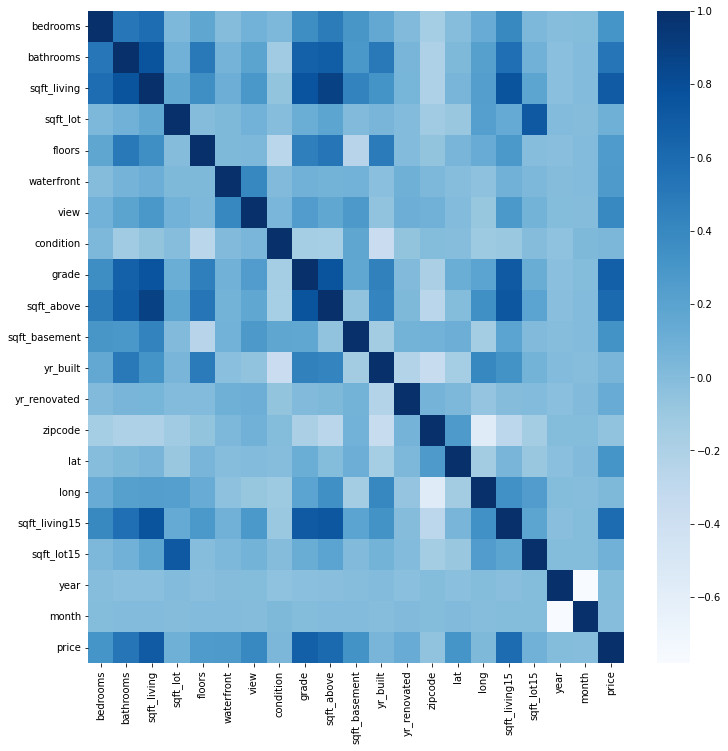

In [8]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), cmap='Blues')

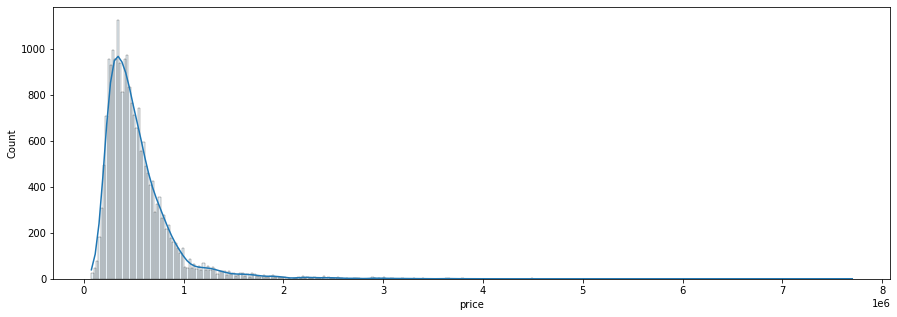

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='price', ax=ax, kde=True, alpha=0.1);

<AxesSubplot:xlabel='price'>

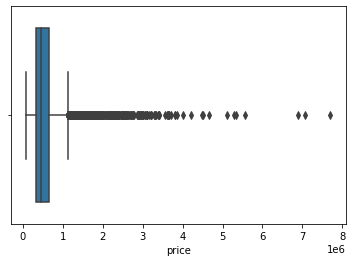

In [10]:
sns.boxplot(data=df, x='price')

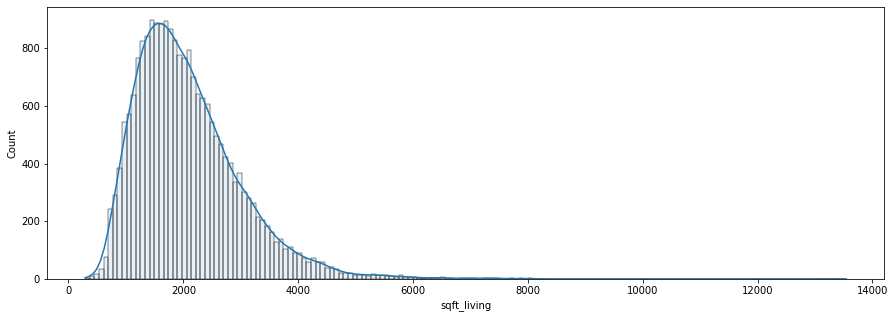

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_living', ax=ax, kde=True, alpha=0.1);

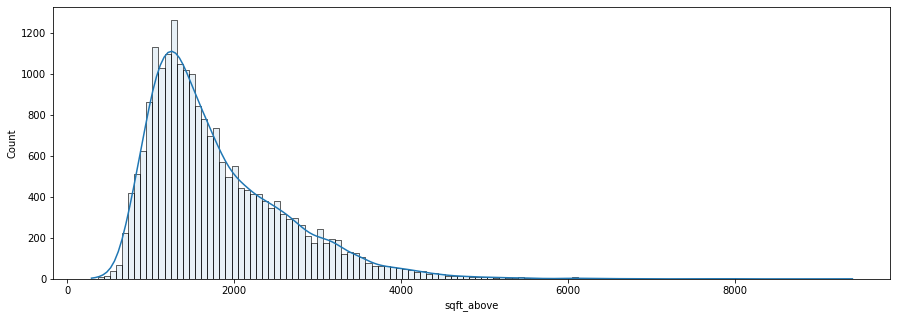

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_above', ax=ax, kde=True, alpha=0.1);

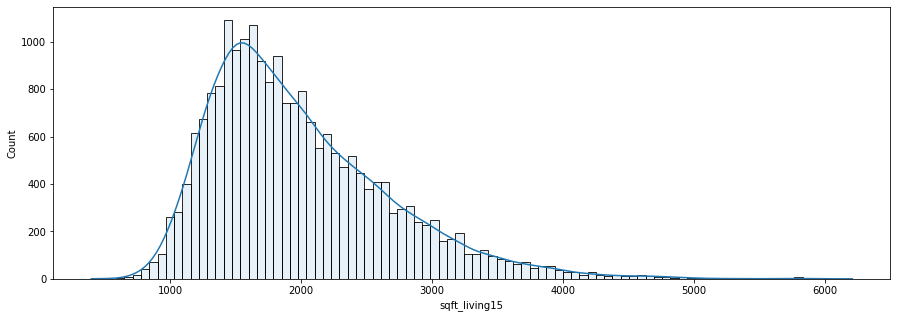

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_living15', ax=ax, kde=True, alpha=0.1);

<AxesSubplot:xlabel='sqft_living15', ylabel='price'>

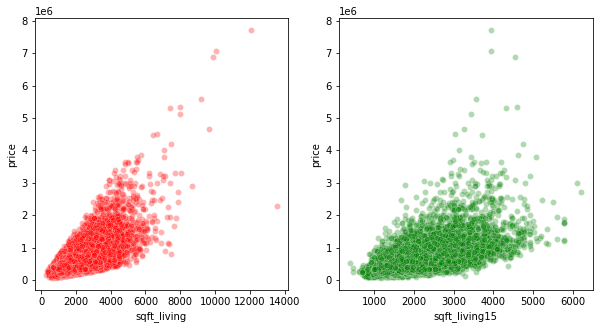

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(data=df, x='sqft_living', y='price', ax=ax[0], alpha=0.3, color='red')
sns.scatterplot(data=df, x='sqft_living15', y='price', ax=ax[1], alpha=0.3, color='green')

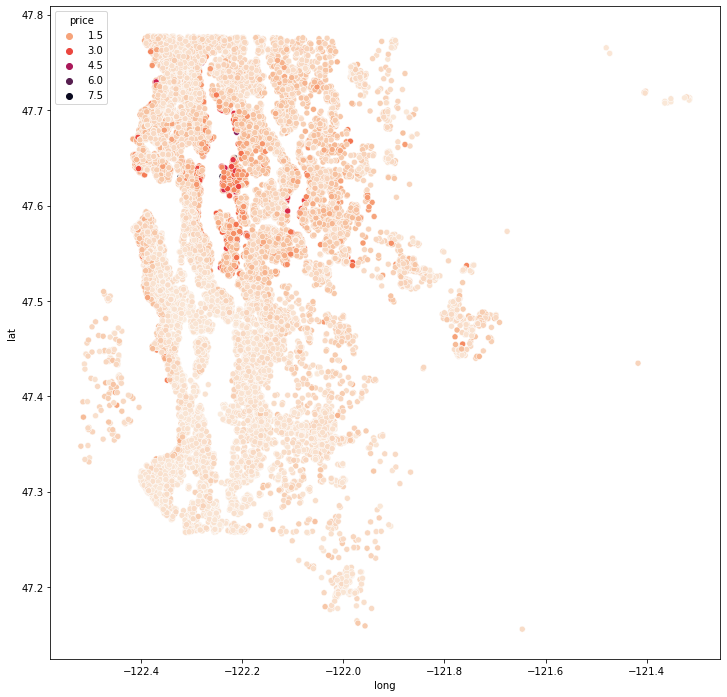

In [15]:
plt.figure(figsize=(12, 12))
sns.scatterplot(data=df, x='long', y='lat', hue='price', palette='rocket_r',);

### Should we remove outliers?
For housing prices, a house could have been sold for a value less than what it worths. Or the house could've been sold more than what it worths. According to the red graph, some house with 13.5k sqft_living has been sold for about 2m dollars but some other house with about 12k sqft_living has been sold for about 7.5m dollars. This case could be seen as an outlier but there are other factors that have impact on the price.

In [16]:
df[df['sqft_living'] > 12000].T

id,6762700020,1225069038
bedrooms,6.000000e+00,7.000000e+00
bathrooms,8.000000e+00,8.000000e+00
sqft_living,1.205000e+04,1.354000e+04
sqft_lot,2.760000e+04,3.077520e+05
floors,2.500000e+00,3.000000e+00
waterfront,0.000000e+00,0.000000e+00
view,3.000000e+00,4.000000e+00
condition,4.000000e+00,3.000000e+00
grade,1.300000e+01,1.200000e+01
sqft_above,8.570000e+03,9.410000e+03


Two houses are somewhat the same and in the same area according to their lat and long. <br>
- More expensive one is older than the new one
- More expensive one's grade is greater than the other by 1 values
- sqft_lot15 is very large compared to the other one
- In 1987, the expensive house has been renovated but the other one hasn't been renovated
<br>
Other than these, the other house is better in every aspect. So why it is less expensive or not at all expensive? <br>
I'd say the first one is expensive because it is near the lake.

In [17]:
def remove_outliers(df, columns='all'):
    columns = df.columns if columns == 'all' else columns
    for c in columns:
        df = remove_columns_outlier(df, c)
    return df

def remove_columns_outlier(df, column):
    column = df[column]
    column_norm = (column - np.mean(column)) / np.std(column)
    column_norm = column_norm[~((column_norm >= 3) | (column_norm <= -3))]
    return df.loc[df.index[df.index.value_counts() == 1]]

def remove_outliers_per(df, column, per_column):
    fraction = column / per_column
    frac_norm = (fraction - np.mean(fraction)) / np.std(fraction)
    frac_norm = frac_norm[~((frac_norm >= 3) | (frac_norm <= -3))]
    return df.loc[list(frac_norm.index)]

def percentage_from_right(df, column, from_value):
    per = df[df[column] > from_value].size / df.size
    per = per * 100
    return per

def percentage_from_left(df, column, from_value):
    per = df[df[column] < from_value].size / df.size
    per = per * 100
    return per
    
def drop_tail_right(df, column, from_value, max_percentage=5):
    per = percentage_from_right(df, column, from_value)
    if per > max_percentage: raise ValueError(f'Percentage ({per:.2f}%) greater than {max_percentage:.2f}%')
    return df[df[column] < from_value]

def drop_tail_left(df, column, from_value, max_percentage=5):
    per = percentage_from_left(df, column, from_value)
    if per > max_percentage: raise ValueError(f'Percentage ({per:.2f}%) greater than {max_percentage:.2f}%')
    return df[df[column] > from_value]


def remove_outliers_IQR(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    IQR = q3 - q1
    res = drop_tail_right(df, column, q3 + 1.5 * IQR, 100)
    res = drop_tail_left(res, column, q1 - 1.5 * IQR, 100)
    per = percentage_from_right(df, column, q3 + 1.5 * IQR) + percentage_from_left(df, column, q1 - 1.5 * IQR)
    print(f'dropping {per:.2f}% data')
    return res

In [18]:
#df = remove_outliers(df, ['price'])
#df = remove_outliers_per(df, df['price'], df['sqft_living'])
#df = remove_outliers_per(df, df['price'], df['sqft_above'])
#df = remove_outliers_per(df, df['price'], df['sqft_living15'])

#df = drop_tail_right(df, 'price', 969000, 9)
#df = drop_tail_right(df, 'sqft_living', 3850, 3)
#df = drop_tail_right(df, 'sqft_living15', 3500, 3)
#df = drop_tail_left(df, 'grade', 5, 5)
#df = drop_tail_right(df, 'grade', 11, 5)

df = remove_outliers_IQR(df, 'price')
df = remove_outliers_IQR(df, 'sqft_living')
df = df.drop('sqft_above', axis=1)

dropping 5.31% data
dropping 1.46% data


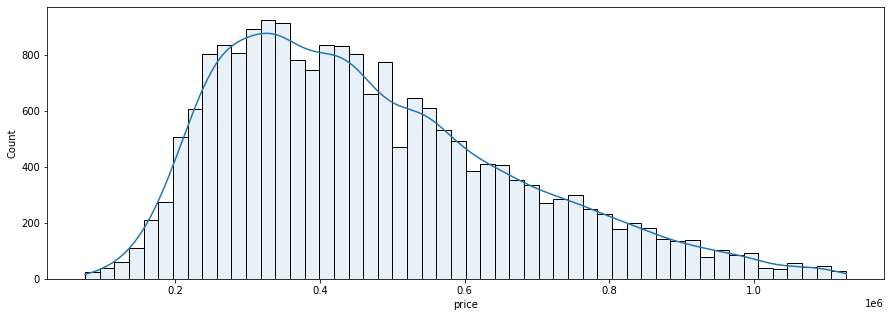

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='price', ax=ax, kde=True, alpha=0.1);

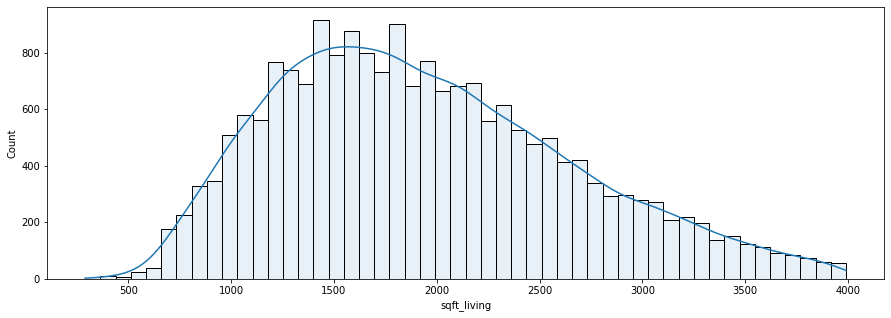

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_living', ax=ax, kde=True, alpha=0.1);

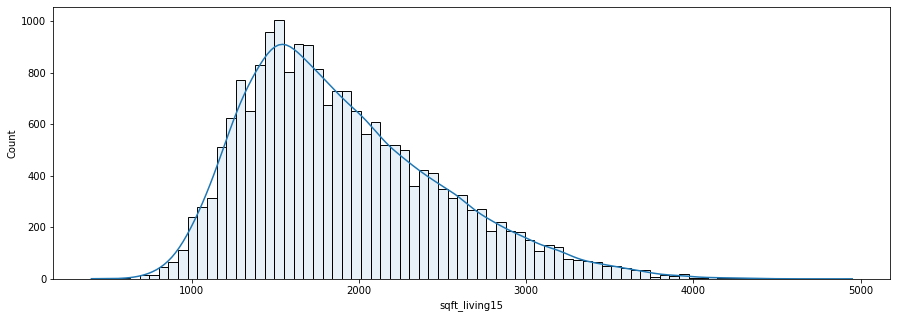

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_living15', ax=ax, kde=True, alpha=0.1);

<AxesSubplot:xlabel='sqft_living15', ylabel='price'>

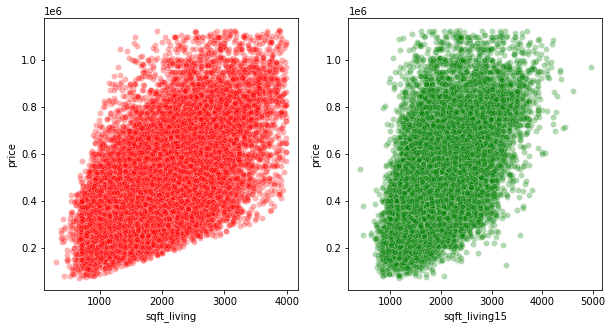

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(data=df, x='sqft_living', y='price', ax=ax[0], alpha=0.3, color='red')
sns.scatterplot(data=df, x='sqft_living15', y='price', ax=ax[1], alpha=0.3, color='green')

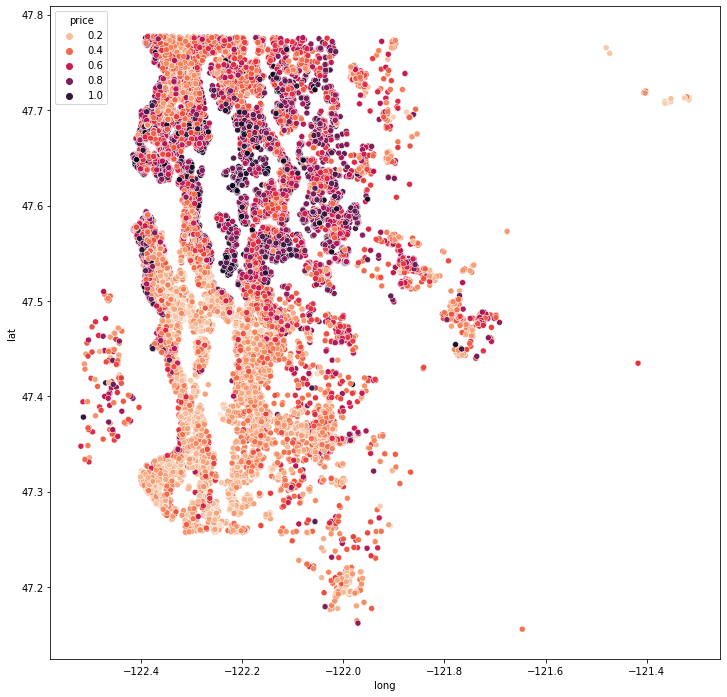

In [23]:
plt.figure(figsize=(12, 12))
sns.scatterplot(data=df, x='long', y='lat', hue='price', palette='rocket_r',);

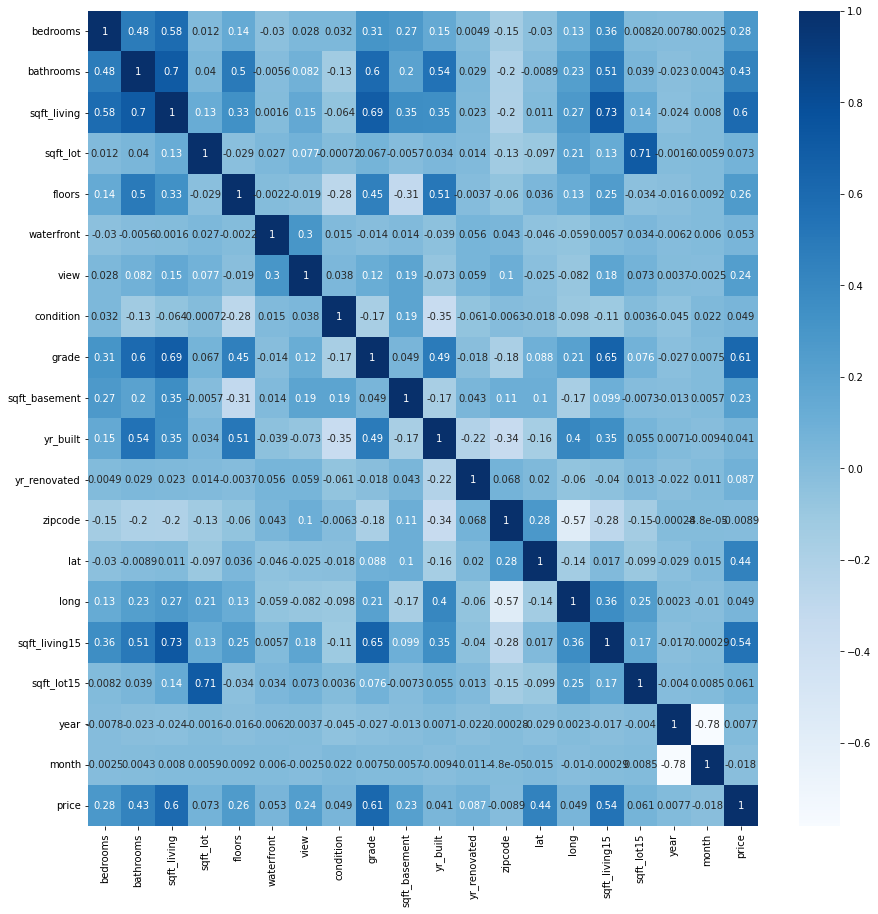

In [24]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), cmap='Blues', annot=True);

In [25]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,19994.0,3.313344,0.901543,0.0000,3.000,3.0000,4.0000,3.300000e+01
bathrooms,19994.0,2.033072,0.689838,0.0000,1.500,2.0000,2.5000,5.750000e+00
sqft_living,19994.0,1940.666250,715.600277,290.0000,1400.000,1840.0000,2410.0000,3.990000e+03
sqft_lot,19994.0,14052.933430,38063.444096,520.0000,5000.000,7480.0000,10200.0000,1.651359e+06
floors,19994.0,1.471541,0.537184,1.0000,1.000,1.0000,2.0000,3.500000e+00
waterfront,19994.0,0.003001,0.054700,0.0000,0.000,0.0000,0.0000,1.000000e+00
view,19994.0,0.168250,0.632408,0.0000,0.000,0.0000,0.0000,4.000000e+00
condition,19994.0,3.410773,0.648547,1.0000,3.000,3.0000,4.0000,5.000000e+00
grade,19994.0,7.503251,1.003976,1.0000,7.000,7.0000,8.0000,1.100000e+01
sqft_basement,19994.0,260.175353,396.629324,0.0000,0.000,0.0000,500.0000,2.000000e+03


## Getting Data ready for trainning

In [26]:
X_train = df.drop(['price'], axis=1).values
y_train = df['price'].values

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.8, random_state=123)
X_test, X_cv, y_test, y_cv = train_test_split(X_test, y_test, test_size=0.5, random_state=10)

In [27]:
print(f'X_train shape is {X_train.shape} and y_train shape is {y_train.shape}')
print(f'y_cv shape is {X_cv.shape} and y_cv shape is {y_cv.shape}')
print(f'X_test shape is {X_test.shape} and y_test shape is {y_test.shape}')

X_train shape is (15995, 19) and y_train shape is (15995,)
y_cv shape is (2000, 19) and y_cv shape is (2000,)
X_test shape is (1999, 19) and y_test shape is (1999,)


### Normalize the data

In [28]:
norm = Normalization()
norm.adapt(X_train)
Xn_train = norm(X_train)
Xn_cv = norm(X_cv)
Xn_test = norm(X_test)

## Training

In [29]:
hist = []
start, step, end = 10, 5, 201
for estimator in range(start, end, step):
    print(f'applying estimator {estimator}')
    model = XGBRegressor(n_estimators=estimator, max_depth=4, eta=0.1, subsample=0.7, colsample_bytree=0.7)
    model = model.fit(Xn_train, y_train)
    hist.append([
        mean_absolute_error(model.predict(Xn_train), y_train),
        mean_absolute_error(model.predict(Xn_cv), y_cv),
        mean_absolute_error(model.predict(Xn_test), y_test)
    ])

applying estimator 10
applying estimator 15
applying estimator 20
applying estimator 25
applying estimator 30
applying estimator 35
applying estimator 40
applying estimator 45
applying estimator 50
applying estimator 55
applying estimator 60
applying estimator 65
applying estimator 70
applying estimator 75
applying estimator 80
applying estimator 85
applying estimator 90
applying estimator 95
applying estimator 100
applying estimator 105
applying estimator 110
applying estimator 115
applying estimator 120
applying estimator 125
applying estimator 130
applying estimator 135
applying estimator 140
applying estimator 145
applying estimator 150
applying estimator 155
applying estimator 160
applying estimator 165
applying estimator 170
applying estimator 175
applying estimator 180
applying estimator 185
applying estimator 190
applying estimator 195
applying estimator 200


(47469.87961179275, 52993.93073828125)


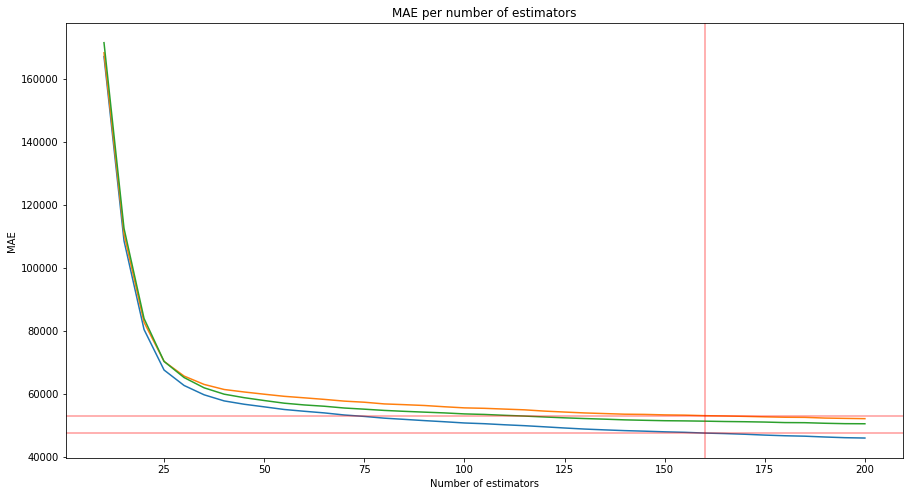

In [30]:
hist = np.array(hist)
train_MAE = hist[:, 0]
cv_MAE = hist[:, 1]
test_MAE = hist[:, 2]

plt.figure(figsize=(15, 8))
plt.plot(range(start, end, step), train_MAE, label='Train MAE');
plt.plot(range(start, end, step), cv_MAE, label='Crossvalidation MAE');
plt.plot(range(start, end, step), test_MAE, label='Test MAE');
plt.title('MAE per number of estimators')
plt.xlabel('Number of estimators')
plt.ylabel('MAE')

x=160
plt.axvline(x=x, c='red', alpha=0.4)
plt.axhline(y=cv_MAE[(x - start) // step], c='red', alpha=0.4)
plt.axhline(y=train_MAE[(x - start) // step], c='red', alpha=0.4)
print((train_MAE[(x - start) // step], cv_MAE[(x - start) // step]))

In [31]:
model = XGBRegressor(n_estimators=x, max_depth=4, eta=0.1, subsample=0.7, colsample_bytree=0.7)
model = model.fit(Xn_train, y_train)

In [32]:
J_abs_train = mean_absolute_error(model.predict(Xn_train), y_train)
J_abs_cv = mean_absolute_error(model.predict(Xn_cv), y_cv)
J_abs_test = mean_absolute_error(model.predict(Xn_test), y_test)

print(f'Absolute error for training set is {J_abs_train}')
print(f'Absolute error for cross validation set is {J_abs_cv}')
print(f'Absolute error for test set is {J_abs_test}')

Absolute error for training set is 47469.87961179275
Absolute error for cross validation set is 52993.93073828125
Absolute error for test set is 51249.41410549024


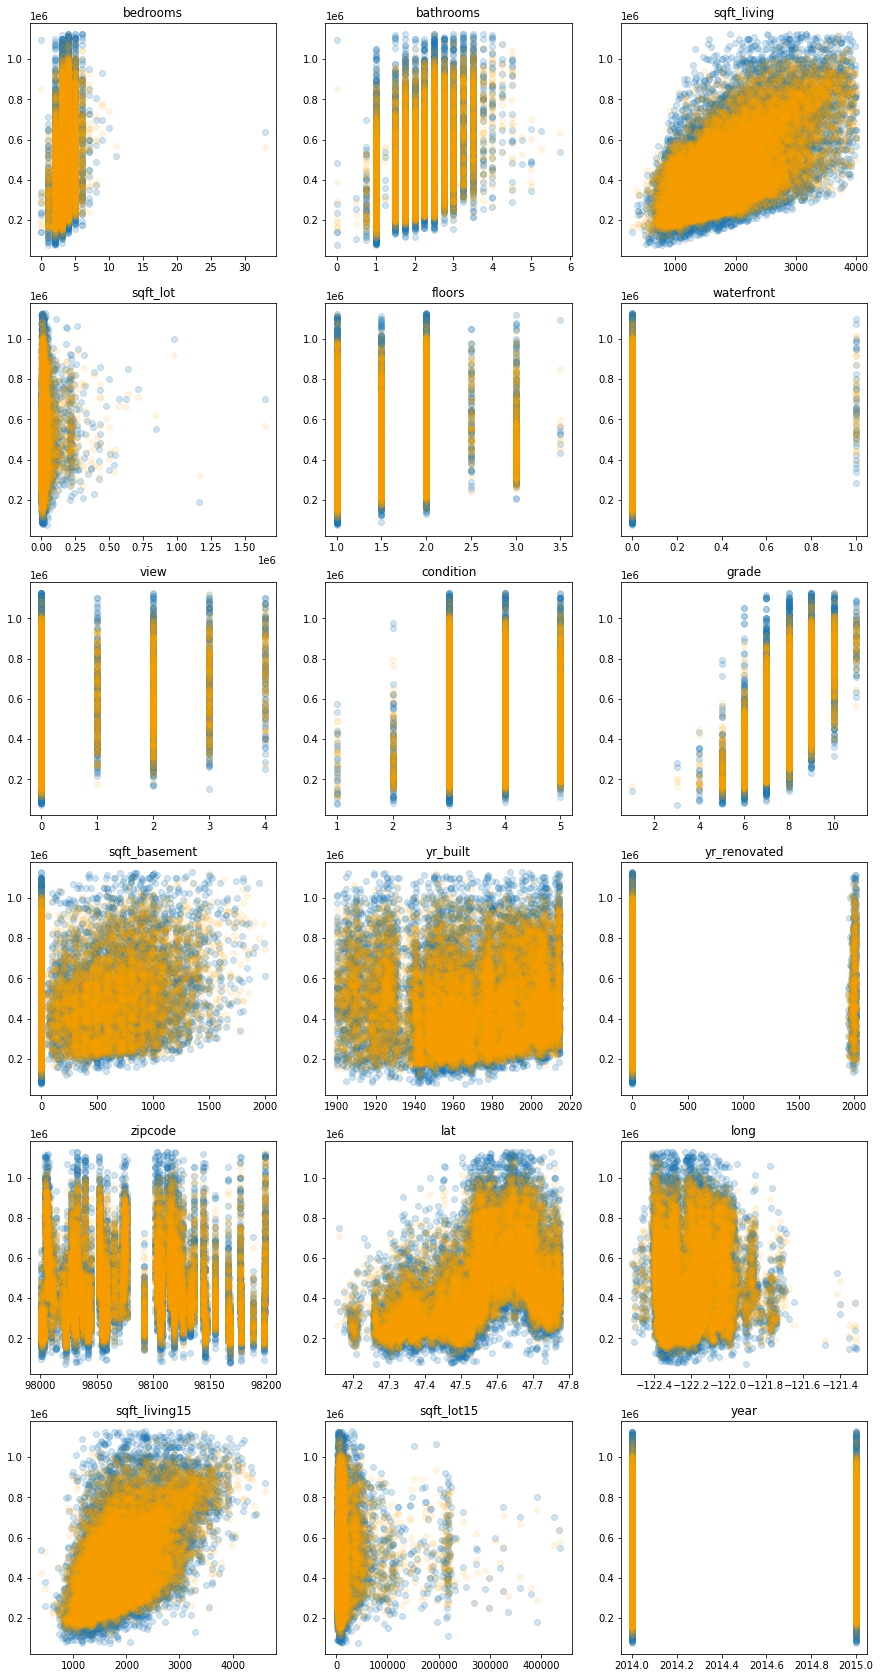

In [33]:
fig, ax = plt.subplots(6, 3, figsize=(15, 30))
m, n = Xn_train.shape
cnt = 0
for ax in ax.flatten():
    try:
        if cnt >= n:
            ax.set_visible(False)
            continue
        newy = model.predict(Xn_train);
        ax.scatter(X_train[:, cnt], y_train, alpha=0.2)
        ax.scatter(X_train[:, cnt], newy, alpha=0.1, c='orange')
        ax.set_title(df.drop('price', axis=1).columns[cnt])
        cnt += 1
    except:
        ax.set_visible(False)
        continue

In [34]:
X_all = df.drop(['price'], axis=1).values
Xn_all = norm(X_all)
p_df = df.copy(deep=True)
p_df['Predicted'] = model.predict(Xn_all).astype('int64')
p_df

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,price,Predicted
id,,,,,,,,,,,,,,,,,,,,,
7129300520,3,1.00,1180,5650,1.0,0,0,3,7,0,...,0,98178,47.5112,-122.257,1340,5650,2014,10,221900.0,218550
6414100192,3,2.25,2570,7242,2.0,0,0,3,7,400,...,1991,98125,47.7210,-122.319,1690,7639,2014,12,538000.0,547278
5631500400,2,1.00,770,10000,1.0,0,0,3,6,0,...,0,98028,47.7379,-122.233,2720,8062,2015,2,180000.0,255850
2487200875,4,3.00,1960,5000,1.0,0,0,5,7,910,...,0,98136,47.5208,-122.393,1360,5000,2014,12,604000.0,426582
1954400510,3,2.00,1680,8080,1.0,0,0,3,8,0,...,0,98074,47.6168,-122.045,1800,7503,2015,2,510000.0,520419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,3,2.50,1530,1131,3.0,0,0,3,8,0,...,0,98103,47.6993,-122.346,1530,1509,2014,5,360000.0,418443
6600060120,4,2.50,2310,5813,2.0,0,0,3,8,0,...,0,98146,47.5107,-122.362,1830,7200,2015,2,400000.0,430515
1523300141,2,0.75,1020,1350,2.0,0,0,3,7,0,...,0,98144,47.5944,-122.299,1020,2007,2014,6,402101.0,323650


In [35]:
df.to_csv('output_XGB.csv', index=True)